# 05 - Skill Extractor Model

This notebook develops and evaluates the Skill Extractor model that extracts skills
from user-provided text using semantic similarity.

**Inputs:**
- `skill_taxonomy.parquet` — 1,498 normalized skills
- `skill_embeddings.parquet` — 384-dim vectors (all-MiniLM-L6-v2)
- `skill_synonyms.json` — 54 synonym mappings

**Outputs:**
- `skill_taxonomy_categorized.parquet` — taxonomy with 5-category labels
- ChromaDB `skill_taxonomy` collection (populated)
- Validated `SkillExtractor` class in `ml/src/skill_extractor.py`

## 5.1 Setup & Load Data

In [1]:
import sys
sys.path.insert(0, str(__import__('pathlib').Path.cwd().parent.parent))

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sentence_transformers import SentenceTransformer
import chromadb
import warnings
warnings.filterwarnings('ignore')

PROCESS_DIR = Path('../data/process')

# Load existing artifacts
df_taxonomy = pd.read_parquet(PROCESS_DIR / 'skill_taxonomy.parquet')
df_embeddings = pd.read_parquet(PROCESS_DIR / 'skill_embeddings.parquet')
with open(PROCESS_DIR / 'skill_synonyms.json') as f:
    synonyms = json.load(f)

# Add skill name column to embeddings (aligned by index with taxonomy)
if 'skill' not in df_embeddings.columns:
    df_embeddings.insert(0, 'skill', df_taxonomy['skill_name'].values)

print(f'Taxonomy: {len(df_taxonomy)} skills')
print(f'Embeddings: {df_embeddings.shape}')
print(f'Synonyms: {len(synonyms)} mappings')
print(f'\nTaxonomy columns: {list(df_taxonomy.columns)}')
print(f'Embedding columns: {df_embeddings.columns[0]} + {df_embeddings.shape[1]-1} dims')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Taxonomy: 1498 skills
Embeddings: (1498, 385)
Synonyms: 54 mappings

Taxonomy columns: ['skill_id', 'skill_name', 'total_count', 'source_count', 'sources']
Embedding columns: skill + 384 dims


## 5.2 Skill Category Assignment

Assign each of the 1,498 skills to one of 5 categories using a seed-centroid approach:
1. Define seed skills per category
2. Compute centroid embedding per category
3. Assign each skill to the nearest centroid

In [2]:
from ml.src.config import CATEGORY_SEEDS
from ml.src.skill_category_classifier import build_category_centroids, classify_skills

# Build centroids from seed skills
centroids = build_category_centroids(df_embeddings, CATEGORY_SEEDS)

print('Category centroids built:')
for cat, vec in centroids.items():
    # Count how many seeds were found
    skill_names = set(df_embeddings['skill'].values)
    found = [s for s in CATEGORY_SEEDS[cat] if s in skill_names]
    print(f'  {cat:25s} {len(found):2d}/{len(CATEGORY_SEEDS[cat]):2d} seeds found, centroid norm: {np.linalg.norm(vec):.3f}')

Category centroids built:
  tech_skills               25/25 seeds found, centroid norm: 0.495
  soft_skills               13/16 seeds found, centroid norm: 0.612
  leadership                14/15 seeds found, centroid norm: 0.663
  domain_knowledge          17/18 seeds found, centroid norm: 0.642
  adaptation_skills          7/14 seeds found, centroid norm: 0.615


In [3]:
# Classify all skills
df_categorized = classify_skills(df_taxonomy, df_embeddings, centroids)

print('Category distribution:')
print(df_categorized['category'].value_counts())
print(f'\nAverage confidence: {df_categorized["category_confidence"].mean():.3f}')
print(f'Min confidence: {df_categorized["category_confidence"].min():.3f}')
print(f'Skills with low confidence (<0.3): {(df_categorized["category_confidence"] < 0.3).sum()}')

Category distribution:
category
tech_skills          551
domain_knowledge     432
leadership           290
soft_skills          151
adaptation_skills     74
Name: count, dtype: int64

Average confidence: 0.439
Min confidence: 0.118
Skills with low confidence (<0.3): 147


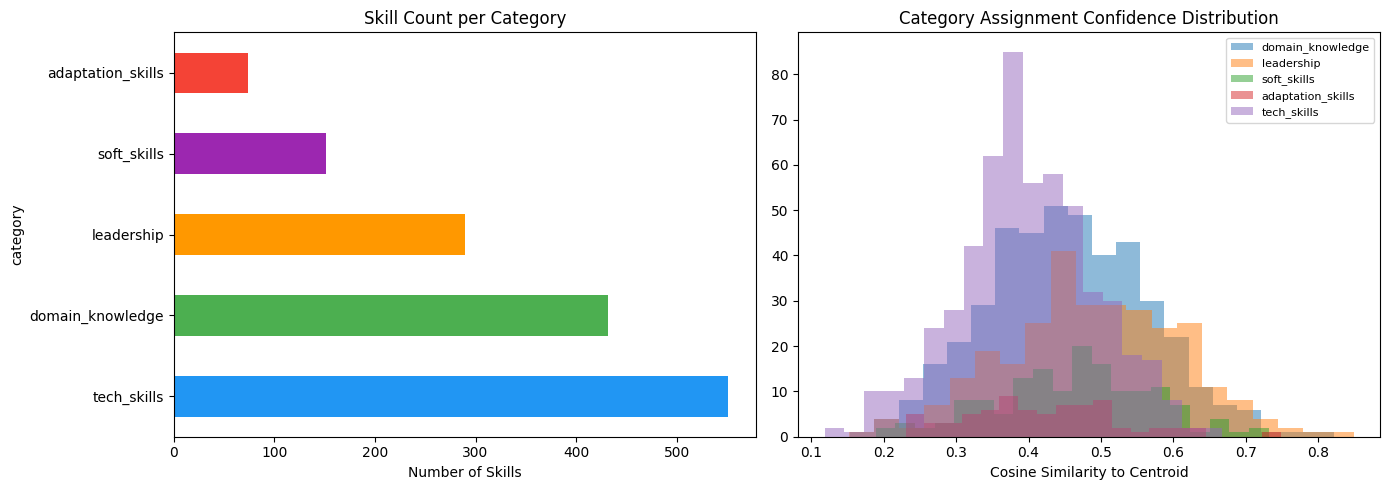

In [4]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
cat_counts = df_categorized['category'].value_counts()
colors = ['#2196F3', '#4CAF50', '#FF9800', '#9C27B0', '#F44336']
cat_counts.plot(kind='barh', ax=axes[0], color=colors[:len(cat_counts)])
axes[0].set_title('Skill Count per Category')
axes[0].set_xlabel('Number of Skills')

# Confidence distribution
for cat in df_categorized['category'].unique():
    subset = df_categorized[df_categorized['category'] == cat]
    axes[1].hist(subset['category_confidence'], bins=20, alpha=0.5, label=cat)
axes[1].set_title('Category Assignment Confidence Distribution')
axes[1].set_xlabel('Cosine Similarity to Centroid')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig('figures/skill_category_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# Spot-check: Show top 10 skills per category
print('Top 10 skills per category (by total_count):\n')
for cat in ['tech_skills', 'soft_skills', 'leadership', 'domain_knowledge', 'adaptation_skills']:
    subset = df_categorized[df_categorized['category'] == cat].nlargest(10, 'total_count')
    skills = ', '.join(subset['skill_name'].tolist())
    print(f'{cat}:')
    print(f'  {skills}\n')

Top 10 skills per category (by total_count):

tech_skills:
  computer science, python, energy modeling, climate data analysis, cloud, sql, automation, tensorflow, pytorch, quantum algorithms

soft_skills:
  design, communication, research, analysis, analytical, education, collaboration, culture, solidity, art/creative

leadership:
  management, development, project management, administrative, planning, training, leadership, supervision, software development, and development

domain_knowledge:
  information technology, sales, engineering, manufacturing, health care provider, business development, other, company, finance, business

adaptation_skills:
  environment, innovation, reliability, technology solutions, sustainability, emerging technologies, mitigation, self-starter, willingness to learn, adaptability



In [6]:
# Save categorized taxonomy
df_categorized.to_parquet(PROCESS_DIR / 'skill_taxonomy_categorized.parquet', index=False)
print(f'Saved: skill_taxonomy_categorized.parquet ({len(df_categorized)} skills with categories)')

Saved: skill_taxonomy_categorized.parquet (1498 skills with categories)


## 5.3 Populate ChromaDB `skill_taxonomy` Collection

In [7]:
from ml.src.chromadb_manager import get_chroma_client, get_ephemeral_client, populate_skill_collection

# Use ephemeral client for notebook testing
# Switch to get_chroma_client() when ChromaDB Docker is running
try:
    chroma_client = get_chroma_client()
    chroma_client.heartbeat()
    print('Connected to ChromaDB Docker instance')
except Exception:
    print('ChromaDB Docker not available, using ephemeral client')
    chroma_client = get_ephemeral_client()

# Populate skill collection
skill_collection = populate_skill_collection(
    chroma_client,
    taxonomy_path=str(PROCESS_DIR / 'skill_taxonomy_categorized.parquet'),
    embeddings_path=str(PROCESS_DIR / 'skill_embeddings.parquet'),
)
print(f'\nSkill collection populated: {skill_collection.count()} skills')

Connected to ChromaDB Docker instance

Skill collection populated: 1498 skills


In [8]:
# Verify: query some known skills
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

test_queries = ['python programming', 'team leadership', 'data analysis', 'cloud infrastructure']
test_embeddings = model.encode(test_queries).tolist()

from ml.src.chromadb_manager import query_skills

results = query_skills(skill_collection, test_embeddings, n_results=3)

for query, matches in zip(test_queries, results):
    print(f'\nQuery: "{query}"')
    for m in matches:
        print(f'  → {m["skill_name"]:30s} [{m["category"]:20s}] sim={m["similarity"]:.3f}')

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1315.99it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Query: "python programming"
  → python programming             [tech_skills         ] sim=1.000
  → python                         [tech_skills         ] sim=0.907
  → computer programming           [tech_skills         ] sim=0.696

Query: "team leadership"
  → team leadership                [leadership          ] sim=1.000
  → leadership                     [leadership          ] sim=0.827
  → team management                [leadership          ] sim=0.809

Query: "data analysis"
  → data analysis                  [tech_skills         ] sim=1.000
  → analysis                       [soft_skills         ] sim=0.793
  → statistical analysis           [tech_skills         ] sim=0.778

Query: "cloud infrastructure"
  → cloud infrastructure           [tech_skills         ] sim=1.000
  → cloud services                 [tech_skills         ] sim=0.829
  → cloud technologies             [tech_skills         ] sim=0.818


## 5.4 Skill Extraction — Comma-Separated Input

In [9]:
from ml.src.skill_extractor import SkillExtractor

extractor = SkillExtractor(
    chroma_client=chroma_client,
    model=model,
    threshold=0.45,
    taxonomy_path=str(PROCESS_DIR / 'skill_taxonomy_categorized.parquet'),
)

# Test cases for comma-separated input
test_inputs = [
    'Python, Machine Learning, SQL, AWS',
    'ML, JS, K8s, CI/CD',  # synonym handling
    'data analysis, storytelling, team leadership, project management',
    'React, TypeScript, Node.js, GraphQL, Docker',
    'deep learning, NLP, computer vision, PyTorch',
]

for input_text in test_inputs:
    print(f'\nInput: "{input_text}"')
    results = extractor.extract_from_skill_list(input_text)
    for r in results:
        conf_label = '★' if r.confidence >= 0.7 else '○'
        print(f'  {conf_label} {r.skill_name:30s} [{r.category:20s}] conf={r.confidence:.3f} (from: "{r.matched_from}")')


Input: "Python, Machine Learning, SQL, AWS"
  ★ python                         [tech_skills         ] conf=1.000 (from: "python")
  ★ machine learning               [tech_skills         ] conf=1.000 (from: "machine learning")
  ★ sql                            [tech_skills         ] conf=1.000 (from: "sql")
  ★ amazon web services            [tech_skills         ] conf=1.000 (from: "amazon web services")

Input: "ML, JS, K8s, CI/CD"
  ★ machine learning               [tech_skills         ] conf=1.000 (from: "machine learning")
  ★ javascript                     [tech_skills         ] conf=1.000 (from: "javascript")
  ★ kubernetes                     [tech_skills         ] conf=1.000 (from: "kubernetes")
  ★ cicd                           [domain_knowledge    ] conf=1.000 (from: "cicd")

Input: "data analysis, storytelling, team leadership, project management"
  ★ data analysis                  [tech_skills         ] conf=1.000 (from: "data analysis")
  ★ storytelling                  

## 5.5 Skill Extraction — Free Text Input

In [10]:
# Test with sample CV/resume paragraphs
sample_texts = [
    """Experienced data scientist with 5 years of expertise in machine learning,
    deep learning, and natural language processing. Proficient in Python, TensorFlow,
    and PyTorch. Built recommendation systems and deployed models on AWS using Docker
    and Kubernetes. Strong communication and presentation skills.""",
    
    """Full-stack web developer specializing in React, TypeScript, and Node.js.
    Experience with PostgreSQL, MongoDB, and Redis for database management.
    Implemented CI/CD pipelines using GitHub Actions and Docker.
    Agile methodology practitioner with strong problem-solving abilities.""",
    
    """Project manager with PMP certification and 8 years leading cross-functional
    teams in the fintech industry. Expert in stakeholder management, risk assessment,
    and strategic planning. Proficient with Jira, Confluence, and data visualization
    tools like Tableau and Power BI.""",
]

for i, text in enumerate(sample_texts, 1):
    print(f'\n{"="*60}')
    print(f'Sample {i}:')
    print(f'{text[:100]}...')
    print(f'{"="*60}')
    results = extractor.extract_from_text(text)
    for r in results:
        conf_label = '★' if r.confidence >= 0.7 else '○'
        print(f'  {conf_label} {r.skill_name:30s} [{r.category:20s}] conf={r.confidence:.3f}')
    print(f'  Total skills extracted: {len(results)}')


Sample 1:
Experienced data scientist with 5 years of expertise in machine learning,
    deep learning, and nat...
  ★ natural language processing    [tech_skills         ] conf=1.000
  ★ data scientist                 [tech_skills         ] conf=1.000
  ★ machine learning               [tech_skills         ] conf=1.000
  ★ deep learning                  [tech_skills         ] conf=1.000
  ★ data                           [tech_skills         ] conf=1.000
  ★ python                         [tech_skills         ] conf=1.000
  ★ tensorflow                     [tech_skills         ] conf=1.000
  ★ pytorch                        [tech_skills         ] conf=1.000
  ★ amazon web services            [tech_skills         ] conf=1.000
  ★ docker                         [tech_skills         ] conf=1.000
  ★ kubernetes                     [tech_skills         ] conf=1.000
  ★ presentation skills            [soft_skills         ] conf=1.000
  ★ communication                  [soft_skills         ]

In [11]:
# Threshold tuning: test different thresholds
thresholds = [0.35, 0.40, 0.45, 0.50, 0.55]

# Use a known text with expected skills
test_text = """Python developer experienced in machine learning, data science,
SQL databases, cloud computing with AWS, Docker containerization, and agile development."""

expected_skills = {'python', 'machine learning', 'data science', 'sql', 
                   'amazon web services', 'docker', 'agile', 'cloud computing'}

print('Threshold tuning:')
print(f'Expected skills: {expected_skills}\n')

for thresh in thresholds:
    extractor_t = SkillExtractor(
        chroma_client=chroma_client, model=model, threshold=thresh,
        taxonomy_path=str(PROCESS_DIR / 'skill_taxonomy_categorized.parquet'),
    )
    results = extractor_t.extract_from_text(test_text)
    extracted = {r.skill_name for r in results}
    
    tp = len(extracted & expected_skills)
    fp = len(extracted - expected_skills)
    fn = len(expected_skills - extracted)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f'Threshold={thresh:.2f}: extracted={len(extracted):2d}, P={precision:.2f}, R={recall:.2f}, F1={f1:.2f}')
    if fp > 0:
        false_pos = extracted - expected_skills
        print(f'  False positives: {false_pos}')

Threshold tuning:
Expected skills: {'cloud computing', 'amazon web services', 'agile', 'python', 'sql', 'machine learning', 'data science', 'docker'}

Threshold=0.35: extracted=13, P=0.62, R=1.00, F1=0.76
  False positives: {'science', 'containerization', 'cloud', 'data', 'databases'}
Threshold=0.40: extracted=13, P=0.62, R=1.00, F1=0.76
  False positives: {'science', 'containerization', 'cloud', 'data', 'databases'}
Threshold=0.45: extracted=13, P=0.62, R=1.00, F1=0.76
  False positives: {'science', 'containerization', 'cloud', 'data', 'databases'}
Threshold=0.50: extracted=13, P=0.62, R=1.00, F1=0.76
  False positives: {'science', 'containerization', 'cloud', 'data', 'databases'}
Threshold=0.55: extracted=13, P=0.62, R=1.00, F1=0.76
  False positives: {'science', 'containerization', 'cloud', 'data', 'databases'}


## 5.6 Evaluation

Evaluate the skill extractor on a hand-crafted test set.

In [12]:
# Evaluation test set
eval_cases = [
    {
        'input': 'Python, TensorFlow, Deep Learning, SQL',
        'mode': 'csv',
        'expected': {'python', 'tensorflow', 'deep learning', 'sql'},
    },
    {
        'input': 'ML, AI, NLP, K8s, AWS',
        'mode': 'csv',
        'expected': {'machine learning', 'artificial intelligence', 'natural language processing', 'kubernetes', 'amazon web services'},
    },
    {
        'input': 'React, Node.js, TypeScript, PostgreSQL, Docker',
        'mode': 'csv',
        'expected': {'react', 'nodejs', 'typescript', 'postgresql', 'docker'},
    },
    {
        'input': 'I have experience building machine learning models using Python and scikit-learn',
        'mode': 'text',
        'expected': {'machine learning', 'python', 'scikit-learn'},
    },
    {
        'input': 'Led a team of 10 engineers using agile methodology and managed stakeholder relationships',
        'mode': 'text',
        'expected': {'agile', 'team leadership', 'stakeholder management'},
    },
    {
        'input': 'Deployed microservices on Kubernetes with CI/CD pipelines using Jenkins and Docker',
        'mode': 'text',
        'expected': {'microservices', 'kubernetes', 'cicd', 'jenkins', 'docker'},
    },
    {
        'input': 'Data visualization expert proficient in Tableau, Power BI, and creating dashboards',
        'mode': 'text',
        'expected': {'data visualization', 'tableau', 'powerbi'},
    },
    {
        'input': 'Experienced in cloud computing with AWS and Google Cloud Platform for scalable applications',
        'mode': 'text',
        'expected': {'cloud computing', 'amazon web services', 'google cloud platform'},
    },
]

total_tp, total_fp, total_fn = 0, 0, 0

for case in eval_cases:
    if case['mode'] == 'csv':
        results = extractor.extract_from_skill_list(case['input'])
    else:
        results = extractor.extract_from_text(case['input'])
    
    extracted = {r.skill_name for r in results}
    expected = case['expected']
    
    tp = len(extracted & expected)
    fp = len(extracted - expected)
    fn = len(expected - extracted)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    status = '✓' if fn == 0 and fp == 0 else '✗'
    print(f'{status} [{case["mode"]:4s}] "{case["input"][:60]}..."')
    if fn > 0:
        print(f'    MISSED: {expected - extracted}')
    if fp > 0:
        print(f'    EXTRA:  {extracted - expected}')

precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f'\n{"="*60}')
print(f'Overall: Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}')
print(f'TP={total_tp}, FP={total_fp}, FN={total_fn}')

✓ [csv ] "Python, TensorFlow, Deep Learning, SQL..."
✓ [csv ] "ML, AI, NLP, K8s, AWS..."
✓ [csv ] "React, Node.js, TypeScript, PostgreSQL, Docker..."
✓ [text] "I have experience building machine learning models using Pyt..."
✗ [text] "Led a team of 10 engineers using agile methodology and manag..."
    MISSED: {'team leadership', 'stakeholder management'}
    EXTRA:  {'agile methodology'}
✓ [text] "Deployed microservices on Kubernetes with CI/CD pipelines us..."
✗ [text] "Data visualization expert proficient in Tableau, Power BI, a..."
    EXTRA:  {'business intelligence', 'data'}
✗ [text] "Experienced in cloud computing with AWS and Google Cloud Pla..."
    EXTRA:  {'cloud'}

Overall: Precision=0.88, Recall=0.94, F1=0.91
TP=29, FP=4, FN=2


In [13]:
print('\n✅ Notebook 05 complete.')
print('Artifacts produced:')
print('  - skill_taxonomy_categorized.parquet (taxonomy with 5 categories)')
print('  - ChromaDB skill_taxonomy collection (populated)')
print('  - SkillExtractor class validated in ml/src/skill_extractor.py')


✅ Notebook 05 complete.
Artifacts produced:
  - skill_taxonomy_categorized.parquet (taxonomy with 5 categories)
  - ChromaDB skill_taxonomy collection (populated)
  - SkillExtractor class validated in ml/src/skill_extractor.py
